# Kush Nagpal Final Project

# Introduction
In this project, I am using the title of articles found on the Internet to detect if an article is real news or fake news.  Determining which news articles are trustworthy and which are not is actually difficult for a lot of people, so I thought creating an LSTM to help classify news as real or fake would be beneficial.

# Imports

In [0]:
import numpy as np
import pandas as pd
import json as j
import urllib
import gzip
import nltk

nltk.download('stopwords')
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
!pip install gensim
from gensim.models import KeyedVectors
from nltk.corpus import stopwords

from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


# Data scanning and parsing

I retrieved my data from a csv file fake_or_real_news.csv.  This consists of the title and text of a select group of news articles.  It then contains a label field which indicates whether the news is real or fake.  In this code block, I scan the csv and clean the titles to filter out stop words and punctuation.


In [0]:
import re
#import sys  

#reload(sys)  
#sys.setdefaultencoding('utf8')


import string
from sklearn.feature_extraction.text import CountVectorizer
def clean_text(text):
    #text = [w.strip() for w in text.readlines()]
    #text.decode('unicode_escape').encode('ascii','ignore')
    text = str(text)
    #text = text.decode("utf8")
    
    text =  text.split()
    words = []
    for word in text:
      exclude = set(string.punctuation)
      word = ''.join(ch for ch in word if ch not in exclude)
      if word in stops:
        continue
      try: 
        words.append(ps.stem(word))
      except UnicodeDecodeError:
        words.append(word)
    text = " ".join(words)
    
    
    return text.lower()


#Process data

stops = set(stopwords.words("english"))

ps = PorterStemmer()

dataset = 'https://www.dropbox.com/s/bxix43wtl06vs74/fake_or_real_news.csv?dl=1'

f = pd.read_csv(dataset)  

f.label = f.label.map(dict(REAL=1, FAKE=0))

f

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",0
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",0
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,1
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,1
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,1


# Text Cleaning

In [0]:
f = f[1:100]

X_train, X_test, y_train, y_test = train_test_split(f['title'], f.label, test_size=0.2)

X_cleaned_train = [clean_text(x) for x in X_train]

X_cleaned_test = [clean_text(x) for x in X_test]



X_cleaned_train[0]

'whi it’ necessari to relax into a stretch'

# Tokenizer

Here I tokenize the data to assign indices to words, and filter out infrequent words.  This allows me to generate sequences for my training and testing data.

In [0]:
import tokenize
from keras.preprocessing.text import Tokenizer

MAX_NB_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_cleaned_train + X_cleaned_test)
print('Finished Building Tokenizer')

train_sequence = tokenizer.texts_to_sequences(X_cleaned_train)
print('Finished Tokenizing Training')

test_sequence = tokenizer.texts_to_sequences(X_cleaned_test)
print('Finished Tokenizing Training')

Finished Building Tokenizer
Finished Tokenizing Training
Finished Tokenizing Training


# Embedding Matrix
I am using an embedding matrix to extract the semantic information from the words in each title.

In [0]:
from gensim.models import KeyedVectors
EMBEDDING_FILE = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

nb_words = min(20000, len(word_index))

embedding_matrix = np.zeros((nb_words, 300))


for word, i in word_index.items():
    try:
      embedding_vector = word2vec.word_vec(word)
      if embedding_vector is not None and i < 7000:
        embedding_matrix[i] = embedding_vector
    except (KeyError, IndexError) as e:
      continue

Found 606 unique tokens


# Building the Model

Here I create the model using an Embedding layer, LSTM, Dropout, and Dense layers.  I am going to run my data on 20 epochs.

In [0]:
from keras.models import Sequential

from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

kVECTORLEN = 50

model = Sequential()
model.add(Embedding(5000, 500, input_length=50))
model.add(LSTM(125))
model.add(Dropout(0.4))
model.add(Dense(1, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


#test_sequence

train_sequence = sequence.pad_sequences(train_sequence, maxlen=50)
test_sequence = sequence.pad_sequences(test_sequence, maxlen=50)

history = model.fit(train_sequence, y_train, validation_data=(test_sequence, y_test), epochs=20, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 500)           2500000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 125)               313000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 125)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 126       
Total params: 2,813,126
Trainable params: 2,813,126
Non-trainable params: 0
_________________________________________________________________
None
Train on 79 samples, validate on 20 samples
Epoch 1/20
79/79 [==============================] - 1s 18ms/step - loss: 5.4024 - acc: 0.4430 - val_loss: 1.6573 - val_acc: 0.3500
Epoch 2/20
79/79 [==============================] - 0s 4ms/step - loss: 1.4112 - acc

In [0]:
scores = model.evaluate(test_sequence, y_test, verbose=0)
accuracy = (scores[1]*100)

print("Accuracy: {:.2f}%".format(scores[1]*100))

Accuracy: 80.00%


# Analyzing the Data

I ran my model on 20 epochs with an accuracy of 80%.  This is good considering the fact that blindly guessing results in a probability of about 60% as there is a total of 60% of articles in the csv that are examples of real news.  The accuracy in my model increased from 44% to 97% and my validation accuracy increased from 35% to 80%.  The loss decreased from 5.4 to 0.01 and the val_loss decreased from 1.65 to 0.53.  The graphs below demonstrate the change in accuracy and loss for the training data as well as the validation data.  One thing to note is I only trained 79 out of the 6334 total data entries since I started to receive memory errors when I attempted to train more data.

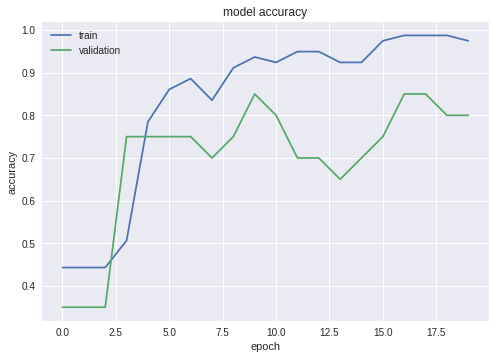

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

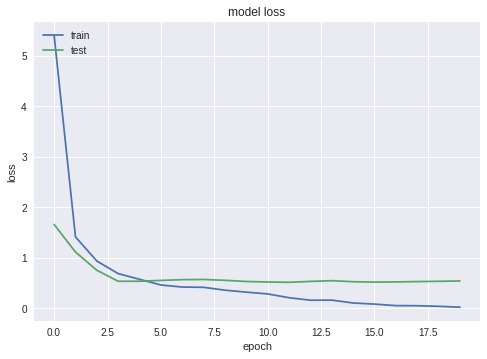

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()